# Missing genotype data on chr.20
### Yosuke Tanigawa (26 July, 2017)

## Summary
- UKBB imputed genotype data has missing values
- this note visualizes the patterns of missing data on several blocks

## Motivation
- We'd like to find prior probability of haplotype based on UKBB genotype data
- However, the dataset has missing genotypes and it is unclear what kind of method is appropriate to cope with this missing values
- This note visualizes the missing data

## Results
- The missing pattern is visualized
- We found that 7-50 % of individuals have no missing values in the block we observed


## Discussion
- Imputation may introduce some haplotypes that does not occur in the population
- The safest way to deal with this problem is exclude alleles (individuals) with missing values in given blocks
- It is unclear whether it is favorable to discard many individuals because they have one or two missing values in the blocks
- Alternative approach would be filter out some variants that has high missing rate. (like >10%)


In [1]:
!git log --oneline |head -n3

ddd9c05 debug: fixed a bug in block.det file to bed file
9736c4b up to mismatch count
ba730f6 need to debug prior count


## Method
### data preparation
### population stratification, MAF>=0.5% filter, SNV only filter
- SNV only filter is introduced because the current implementation does not fully support short in/dels

In [2]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
pgen_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg.log'

In [3]:
!cat $data_dir/$geno_bed_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/private_data/ukbb/pgen/chr20impv1
  --biallelic-only strict
  --geno
  --hwe 1e-10 midp
  --keep /share/PI/mrivas/data/ukbb/phefiles/initialdata/1389.phe
  --maf 0.005
  --make-bed
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --snps-only just-acgt

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:24:21 2017

Random number seed: 1498260261
257674 MB RAM detected; reserving 30000 MB for main workspace.
1540220 out of 1619597 variants loaded from .bim file.
152249 people (0 males, 0 females, 152249 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.nosex
.
--keep: 112338 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Befo

### conversion to pgen file

In [4]:
!cat $data_dir/$pgen_log

PLINK v2.00aLM 64-bit Intel (5 Jun 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --make-bpgen
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg
  --threads 8

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Sat Jun 24 15:07:23 2017

Random number seed: 1498342043
257674 MB RAM detected; reserving 30000 MB for main workspace.
Using up to 8 compute threads.
112338 samples (0 females, 0 males, 112338 ambiguous; 112338 founders) loaded
from
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.fam.
198418 variants loaded from
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.bim.
Note: No phenotype data present.
Writing
/oak/stanford/groups/mrivas/users/ytani

### find LD block structures with --blocks 

In [5]:
!cat $data_dir/$block_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --blocks no-pheno-req no-small-max-span
  --blocks-inform-frac 0.10
  --blocks-max-kb 1000
  --blocks-recomb-highci 0.830001
  --blocks-strong-highci 0.830001
  --blocks-strong-lowci 0.50001
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:32:58 2017

Random number seed: 1498260778
257674 MB RAM detected; reserving 30000 MB for main workspace.
198418 variants loaded from .bim file.
112338 people (0 males, 0 females, 112338 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-bl

### define block structure based on blocks.det file
- https://github.com/rivas-lab/nanopore/blob/master/src/LD_block_to_bed-with-geno-hwe-filters.ipynb

## visualization
- the following python script is used to visualize the missing values

In [6]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
import multiprocessing

from numba import jit

import pgenlib as pg

In [7]:
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

In [8]:
pgen_log[:-4]

'chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg'

In [9]:
data_dir

'/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'

In [10]:
block_log

'chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'

In [13]:
pgen_f = '{}/{}.pgen'.format(data_dir, pgen_log[:-4])
block_bed_f = '{}/{}.bed'.format(data_dir, block_log[:-4])

In [14]:
block_bed = pd.read_csv(block_bed_f, sep='\t', names=['chrom', 'chromStart', 'chromEnd', 'name'])
block_bed['bim_interval'] = block_bed.name.map(lambda x: [int(pos) for pos in x.split(':')])
print(block_bed.shape)
block_bed.head()

(642, 5)


,chrom,chromStart,chromEnd,name,bim_interval
0,chr20,61097,94951,0:78,"[0, 78]"
1,chr20,94951,266791,78:915,"[78, 915]"
2,chr20,266791,288775,915:991,"[915, 991]"
3,chr20,288775,344630,991:1218,"[991, 1218]"
4,chr20,344630,346675,1218:1224,"[1218, 1224]"


In [15]:
def show_missing_genotypes(pgen_f, block_df, block_id):
    geno = read_alleles_block(pgen_f, block_df, block_id)
    geno_isMissing = geno == -9
    print('{}:{}-{} (block {}; length = {:,}bp; #SNPs = {})'.format(
        block_bed.chrom[block_id], block_bed.chromStart[block_id], block_bed.chromEnd[block_id],
        block_id, 
        block_bed.chromEnd[block_id] - block_bed.chromStart[block_id], 
        block_bed.bim_interval[block_id][1] - block_bed.bim_interval[block_id][0]
    ))
    print('{:,} individuals (out of {:,}; {:.2f}%) have no missing value in this block.'.format(
        np.sum(np.sum(geno_isMissing, axis = 0) == 0),
        geno.shape[1],
        100.0 * np.sum(np.sum(geno == -9, axis = 0) == 0) / geno.shape[1]
    ))

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4)
    ax1 = fig.add_subplot(gs[:3, :])
    ax2 = fig.add_subplot(gs[3, :2])
    ax3 = fig.add_subplot(gs[3:,2:])
    ax1.spy(geno_isMissing, aspect = 'auto')
    ax2.hist(np.sum(geno_isMissing, axis=0))
    ax3.hist(np.sum(geno_isMissing, axis=1))
    ax1.set_xlabel('haplotypes in the polulation')
    ax1.set_ylabel('SNPs in this block')
    ax2.set_xlabel('# of SNPs with missing values')
    ax3.set_xlabel('# of alleles with missing values')
    for ax in [ax2, ax3]:
        ax.set_ylabel('Freq.')
    fig.suptitle('missing genotype info in block #{}'.format(block_id))
    gs.tight_layout(fig, rect=[0, 0, 1, .97])
    # fig.savefig('./fig.png')    

In [16]:
def read_alleles_block(pgen_f, block_df, block_id):
    """wrapper function of pgen.PgenReader.read_alleles_range for a LD block"""
    bim_interval = block_df.bim_interval[block_id]
    with pg.PgenReader(pgen_f) as pgr:
        buf_ndary = np.zeros(
            (bim_interval[1] - bim_interval[0], pgr.get_raw_sample_ct() * 2), 
            dtype=np.int32
        )
        pgr.read_alleles_range(bim_interval[0], bim_interval[1], buf_ndary)
    return buf_ndary
#     buf_ndary[buf_ndary == -9] = 0
#     buf_tpls = [tuple(1 - buf_ndary[:, hap]) for hap in range(buf_ndary.shape[1])]
#     return cl.Counter(buf_tpls)

In [17]:
@jit
def count_alleles_freq(genotype_matrix):
    tuples = [tuple(1 - genotype_matrix[:, hap])
              for hap in range(genotype_matrix.shape[1])]
    return cl.Counter(tuples)

chr20:61097-94951 (block 0; length = 33,854bp; #SNPs = 78)
119,900 individuals (out of 224,676; 53.37%) have no missing value in this block.


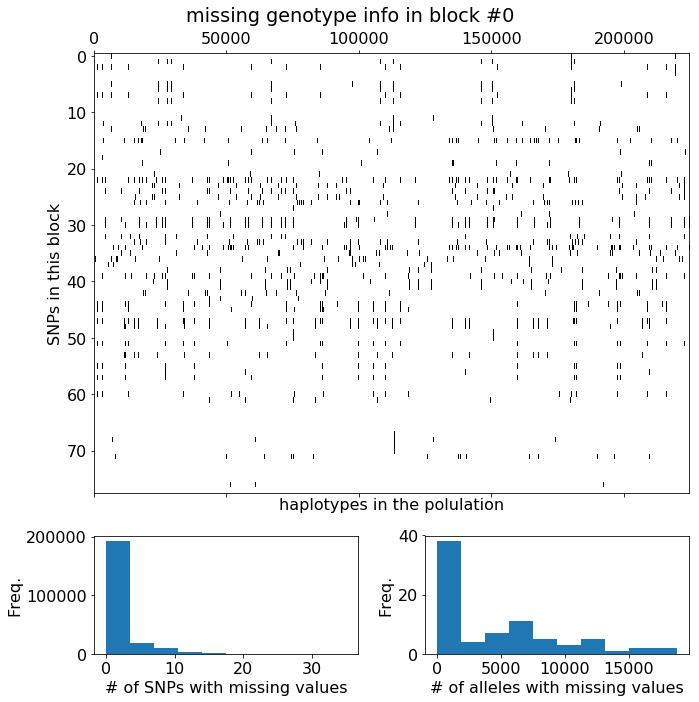

In [18]:
show_missing_genotypes(pgen_f, block_bed, 0)

chr20:94951-266791 (block 1; length = 171,840bp; #SNPs = 837)
24,264 individuals (out of 224,676; 10.80%) have no missing value in this block.


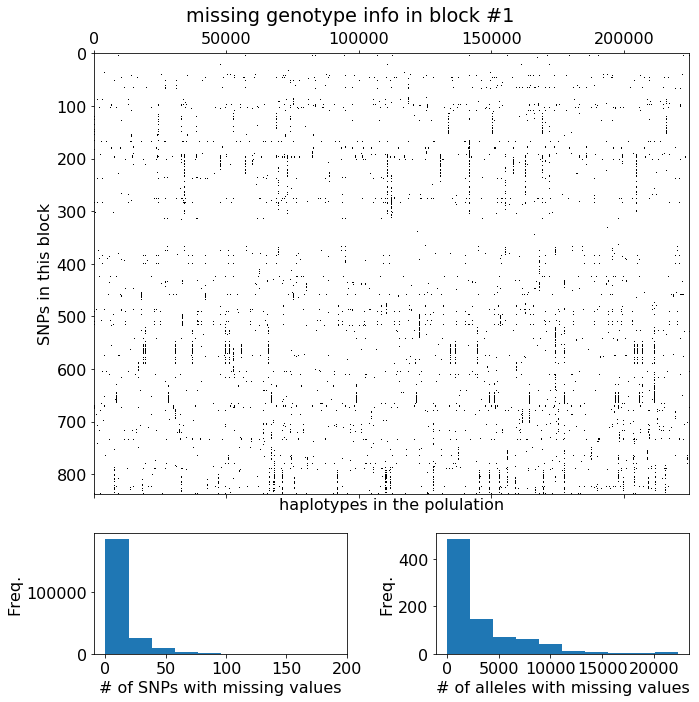

In [19]:
show_missing_genotypes(pgen_f, block_bed, 1)

chr20:266791-288775 (block 2; length = 21,984bp; #SNPs = 76)
120,130 individuals (out of 224,676; 53.47%) have no missing value in this block.


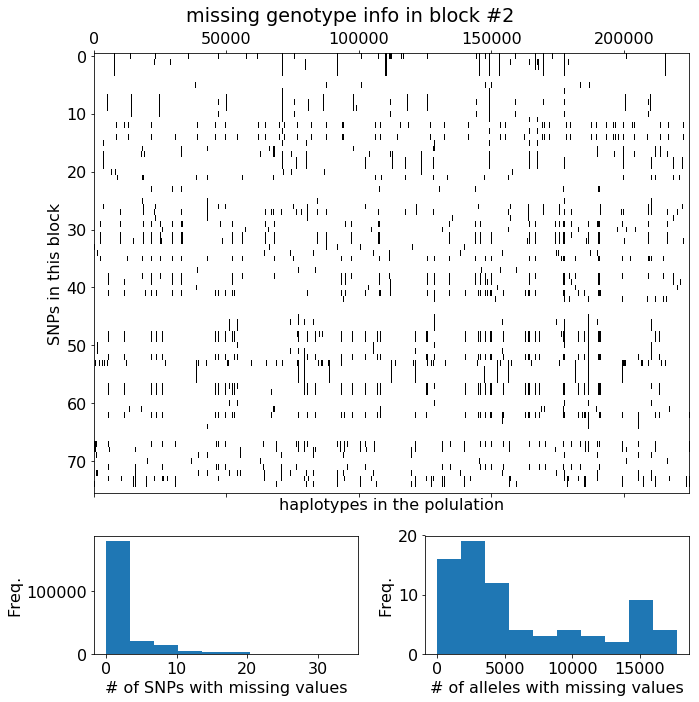

In [20]:
show_missing_genotypes(pgen_f, block_bed, 2)

chr20:288775-344630 (block 3; length = 55,855bp; #SNPs = 227)
70,042 individuals (out of 224,676; 31.17%) have no missing value in this block.


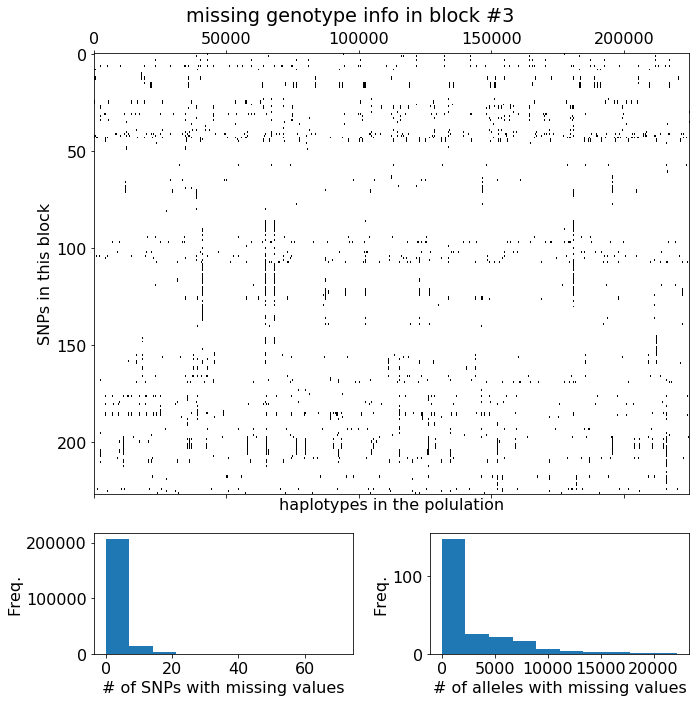

In [21]:
show_missing_genotypes(pgen_f, block_bed, 3)

chr20:344630-346675 (block 4; length = 2,045bp; #SNPs = 6)
202,090 individuals (out of 224,676; 89.95%) have no missing value in this block.


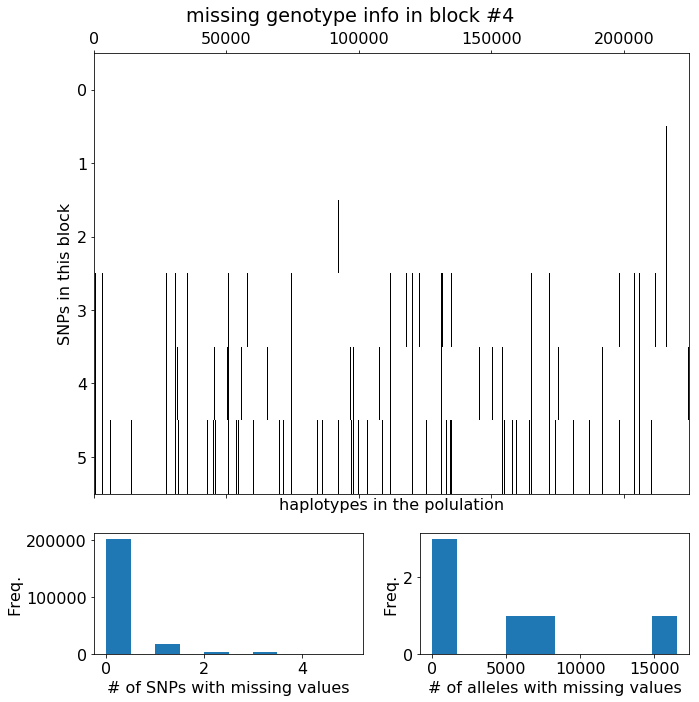

In [22]:
show_missing_genotypes(pgen_f, block_bed, 4)

chr20:346675-368904 (block 5; length = 22,229bp; #SNPs = 131)
87,266 individuals (out of 224,676; 38.84%) have no missing value in this block.


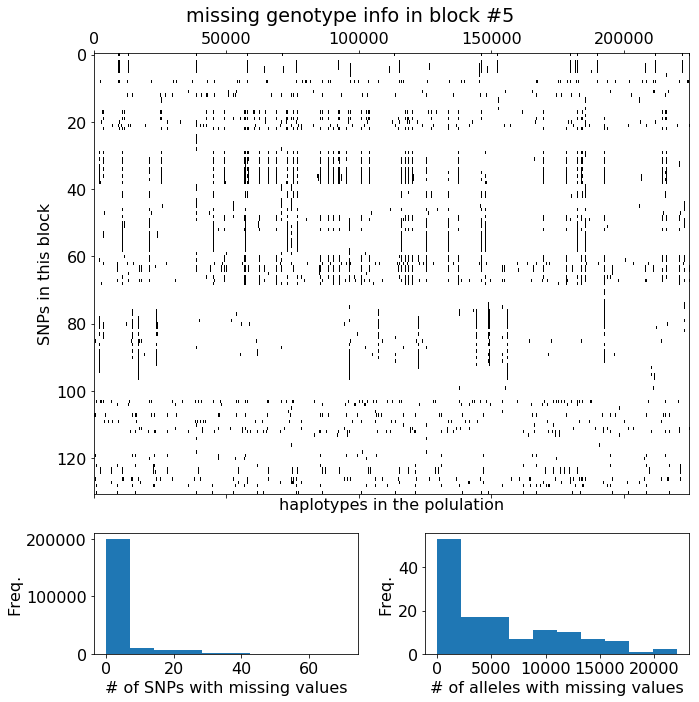

In [23]:
show_missing_genotypes(pgen_f, block_bed, 5)

chr20:368904-381669 (block 6; length = 12,765bp; #SNPs = 50)
167,090 individuals (out of 224,676; 74.37%) have no missing value in this block.


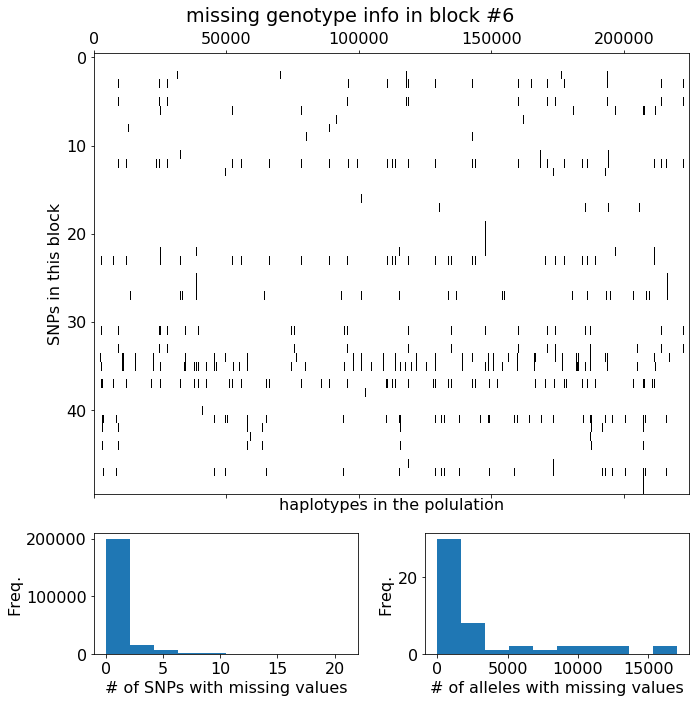

In [24]:
show_missing_genotypes(pgen_f, block_bed, 6)